In [13]:
import pandas as pd
import pvlib
from pvlib.location import Location
import matplotlib.pyplot as plt
import numpy as np
from sympy import*
from scipy.optimize import curve_fit

In [14]:
tidszone = "Europe/Copenhagen"
start_dato = "2024-01-01"
slut_dato = "2024-12-31"
delta_tid = "Min"  # "Min", "H",

# Definition of Location object. Coordinates and elevation of Amager, Copenhagen (Denmark)
site = Location(
    55.47092, 12.31168, tidszone, 10, "Danmarks Tekniske Universitet (DK)"
)  # latitude, longitude, time_zone, altitude, name

# Højde er ca 50 m MOH

# Definition of a time range of simulation
times = pd.date_range(
    start_dato + " 00:00:00", slut_dato + " 23:59:59", inclusive="left", freq=delta_tid, tz=tidszone
)

In [15]:
# Estimate Solar Position with the 'Location' object
solpos = site.get_solarposition(times)

# Visualize the resulting DataFrame
solpos.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2024-01-01 00:00:00+01:00,147.491022,147.491022,-57.491022,-57.491022,354.081669,-3.055576
2024-01-01 00:01:00+01:00,147.505050,147.505050,-57.505050,-57.505050,354.508799,-3.055906
2024-01-01 00:02:00+01:00,147.518026,147.518026,-57.518026,-57.518026,354.936201,-3.056235
2024-01-01 00:03:00+01:00,147.529950,147.529950,-57.529950,-57.529950,355.363856,-3.056565
2024-01-01 00:04:00+01:00,147.540819,147.540819,-57.540819,-57.540819,355.791743,-3.056895


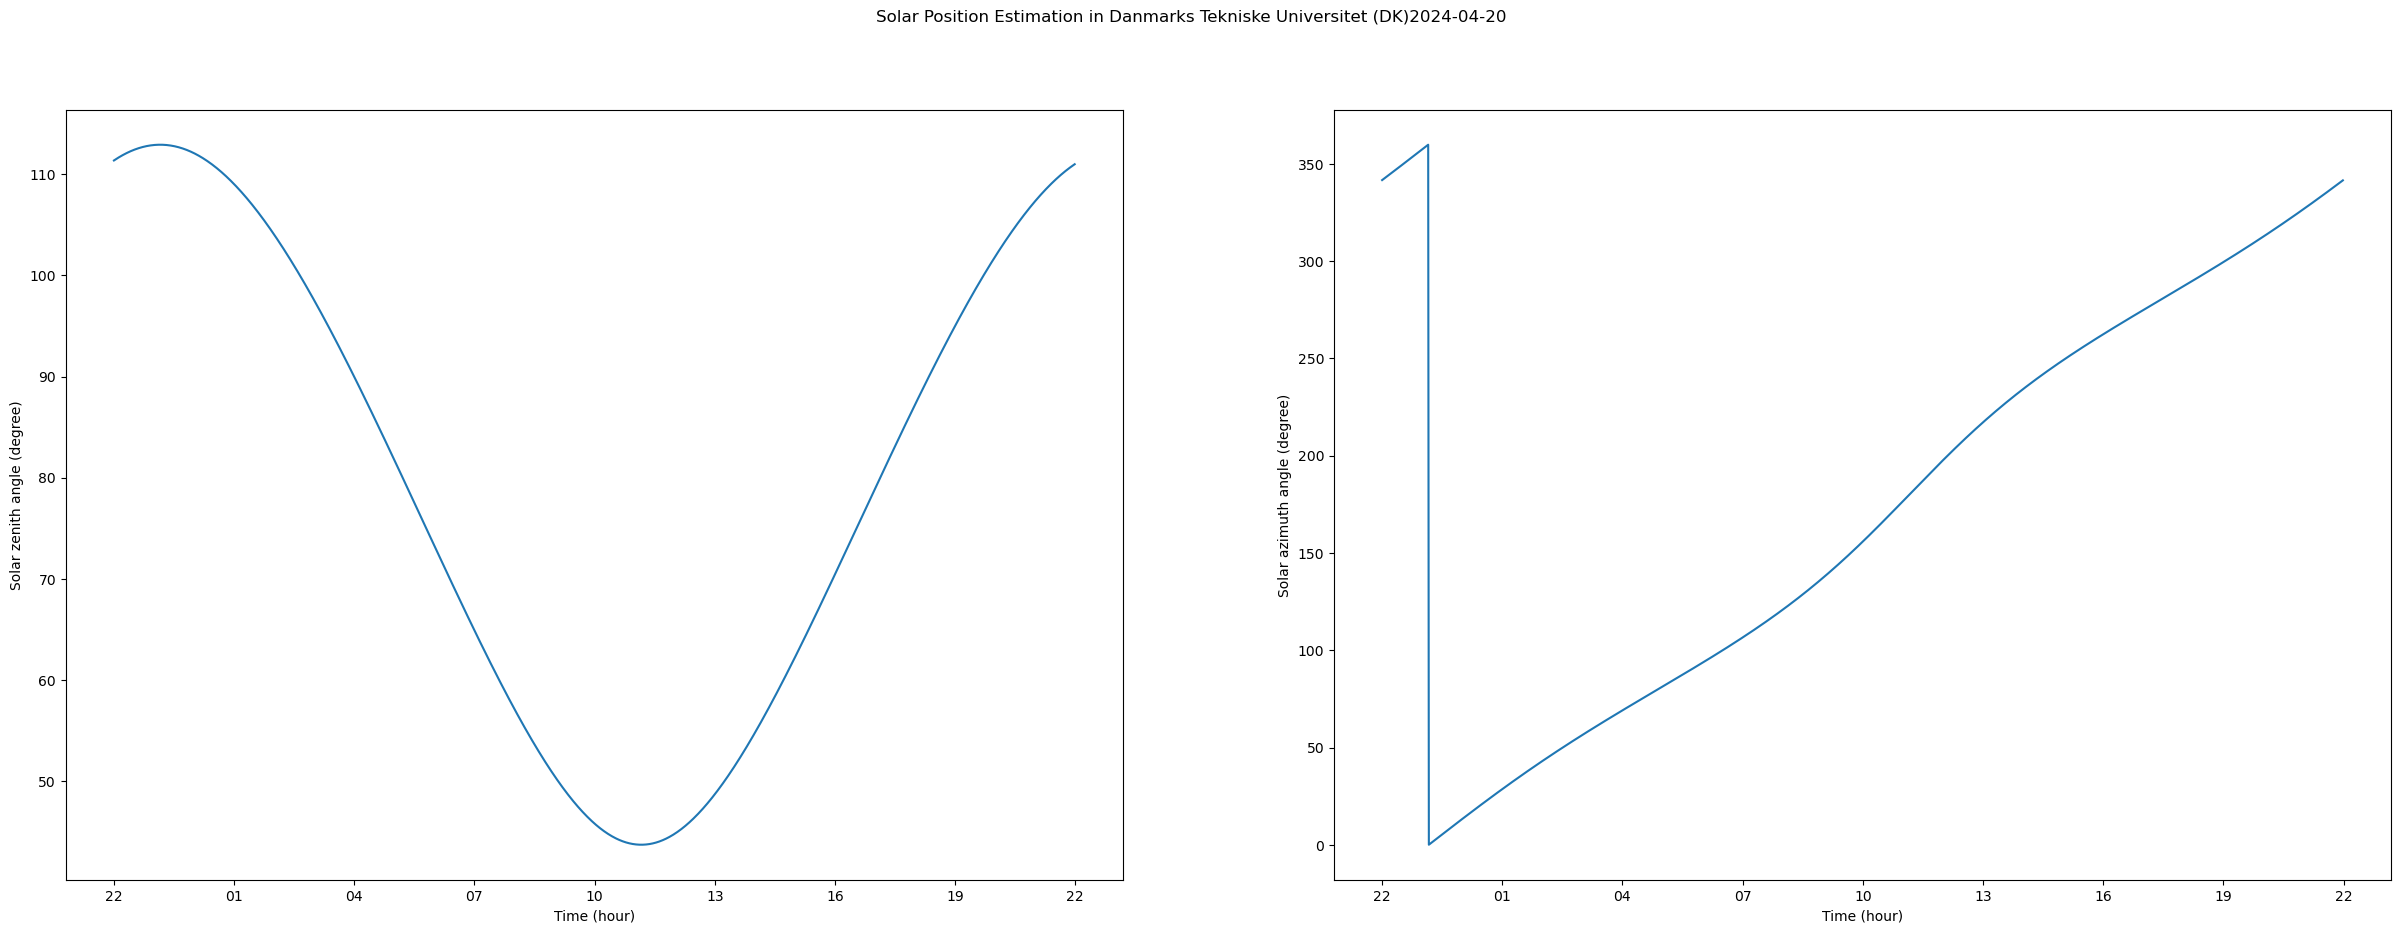

In [16]:
import matplotlib.dates as mdates

valgt_dato = "2024-04-20"

# Plots for solar zenith and solar azimuth angles
fig, (ax1, ax2) = plt.subplots( 1, 2, figsize=(30, 10))
fig.suptitle("Solar Position Estimation in " + site.name + valgt_dato)

# plot for solar zenith angle
ax1.plot(solpos.loc[valgt_dato].zenith)
ax1.set_ylabel("Solar zenith angle (degree)")
ax1.set_xlabel("Time (hour)")
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H"))

# plot for solar azimuth angle
ax2.plot(solpos.loc[valgt_dato].azimuth)
ax2.set_ylabel("Solar azimuth angle (degree)")
ax2.set_xlabel("Time (hour)")
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H"))

In [ ]:
# Approksimation af zenitvinkel
data = solpos.loc[valgt_dato]
t_decimal = data.index.hour + data.index.minute / 60

def zenith_model(t, Mz, Az, Tz):
    omega_z = 2 * np.pi / 24
    return Mz + Az * np.cos(omega_z * (t - Tz))

p0 = [np.mean(data.zenith), (np.max(data.zenith) - np.min(data.zenith)) / 2, 12]
popt_zenith, _ = curve_fit(zenith_model, t_decimal, data.zenith, p0=p0)
Mz, Az, Tz = popt_zenith
Mz, Az, Tz

(79.37965289479403, -33.93060327197155, 13.16954593179442)

In [18]:
# Approksimation af azimutvinkel
mask = data.zenith < 90
t_daylight = t_decimal[mask]
phi = data.azimuth[mask]

def azimuth_model(t, a, b):
    return a * t + b

popt_azimuth, _ = curve_fit(azimuth_model, t_daylight, phi)
a, b = popt_azimuth
a,b

(16.732201638185618, -40.16628636088865)

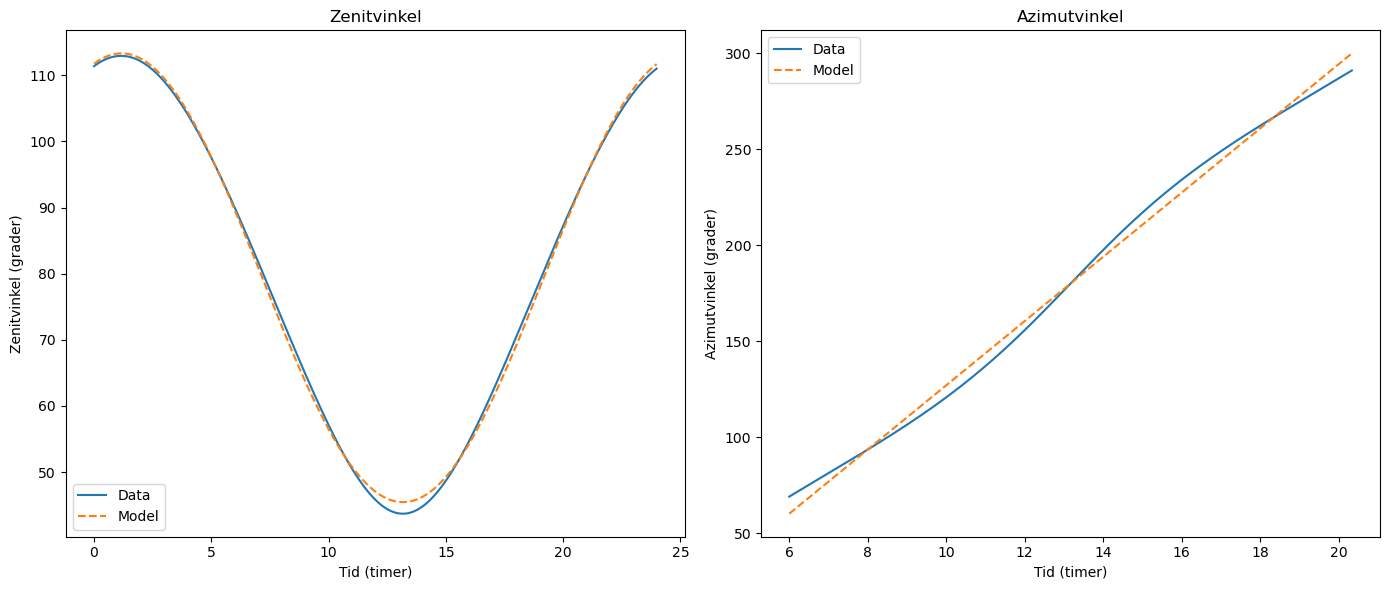

In [19]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Zenit
ax1.plot(t_decimal, data.zenith, label="Data")
ax1.plot(t_decimal, zenith_model(t_decimal, *popt_zenith), "--", label="Model")
ax1.set_title("Zenitvinkel")
ax1.set_xlabel("Tid (timer)")
ax1.set_ylabel("Zenitvinkel (grader)")
ax1.legend()

# Azimut
ax2.plot(t_daylight, phi, label="Data")
ax2.plot(t_daylight, azimuth_model(t_daylight, *popt_azimuth), "--", label="Model")
ax2.set_title("Azimutvinkel")
ax2.set_xlabel("Tid (timer)")
ax2.set_ylabel("Azimutvinkel (grader)")
ax2.legend()

plt.tight_layout()
plt.show()